In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import bpl
import wcpredictor

In [4]:
# training data date range
start_date = "2016-5-1"
end_date = "2022-12-31"

wc_teams = wcpredictor.get_teams_data(year="2022")


In [15]:
confeds = wcpredictor.get_confederations_data()


def conf_int_wc(model, quantile=(0.1, 0.9), nsamples=1000):
    """
    sample team strength + confederation strength to get representative overall
    strengths for NeutralWC model
    """
    attack_raw = model.attack
    defence_raw = model.defence
    confed = model.confederation_strength

    team_attack = np.zeros((nsamples, len(model.teams)))
    team_defence = np.zeros((nsamples, len(model.teams)))

    for team_idx, team in enumerate(model.teams):
        att_samples = np.random.choice(attack_raw[:, team_idx], size=nsamples)
        def_samples = np.random.choice(defence_raw[:, team_idx], size=nsamples)

        team_confed = confeds[confeds["Team"] == team]["Confederation"].iloc[0]
        confed_idx = model.conferences.index(team_confed)
        con_samples = np.random.choice(confed[:, confed_idx], size=nsamples)

        team_attack[:, team_idx] = att_samples + con_samples
        team_defence[:, team_idx] = def_samples + con_samples

    att_mean = team_attack.mean(axis=0)
    def_mean = team_defence.mean(axis=0)

    att_confint = np.abs(np.quantile(team_attack, [0.1, 0.9], axis=0) - att_mean)
    def_confint = np.abs(np.quantile(team_defence, [0.1, 0.9], axis=0) - def_mean)

    return att_mean, def_mean, att_confint, def_confint


def plot_attack_defence(model, quantile=(0.1, 0.9), nsamples=1000):
    att_mean, def_mean, att_conf, def_conf = conf_int_wc(
        model, quantile=quantile, nsamples=nsamples
    )
    wc_teams_idx = {team: idx for idx, team in enumerate(model.teams)
                    if team in wc_teams["Team"].values}

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_aspect("equal")
    select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
    plt.errorbar(
        att_mean[select_idx],
        def_mean[select_idx],
        xerr=att_conf[:, select_idx],
        yerr=def_conf[:, select_idx],
        marker="o",
        markersize=10,
        linestyle="",
        linewidth=0.5,
    )
    plt.xlabel("attack", fontsize=14)
    plt.ylabel("defence", fontsize=14)

    for team, idx in wc_teams_idx.items():
        ax.annotate(team, (att_mean[idx] - 0.03, def_mean[idx] + 0.02), fontsize=12)

## Neutral Model WC + FIFA Game Rankings

In [4]:
wc_pred = wcpredictor.get_and_train_model(
    start_date=start_date,
    end_date=end_date,
    model=bpl.NeutralDixonColesMatchPredictorWC(),
    rankings_source="game",
)
dict(
    zip(
        wc_pred.model.conferences,
        wc_pred.model.confederation_strength.mean(axis=0).tolist(),
    )
)

in get_and_train_model
Using FIFA videogame rankings
Using 5866 rows in training data
Using FIFA videogame rankings
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [06:30<00:00,  3.84it/s, 511 steps of size 6.65e-03. acc. prob=0.95]


{'AFC': -0.10035602748394012,
 'CAF': 0.22741824388504028,
 'CONCACAF': -0.2281181663274765,
 'CONMEBOL': 0.34616705775260925,
 'OFC': -0.13690534234046936,
 'UEFA': 0.17752312123775482,
 'Unaffiliated': -0.45064467191696167}

In [19]:
import jsonpickle

filepath = "/Users/jroberts/GitHub/WorldCupPrediction/wcpredictor/scripts/likelihood_scan_1668514646/1668517918_epsilon_0.2_worldcupweight_1.5.model"
with open(filepath, "rb") as f:
    wc_pred = jsonpickle.decode(f.read())

In [20]:
wc_pred.model.epsilon

0.2

In [21]:
wc_teams_idx = {team: idx for idx, team in enumerate(wc_pred.model.teams)
                if team in wc_teams["Team"].values}

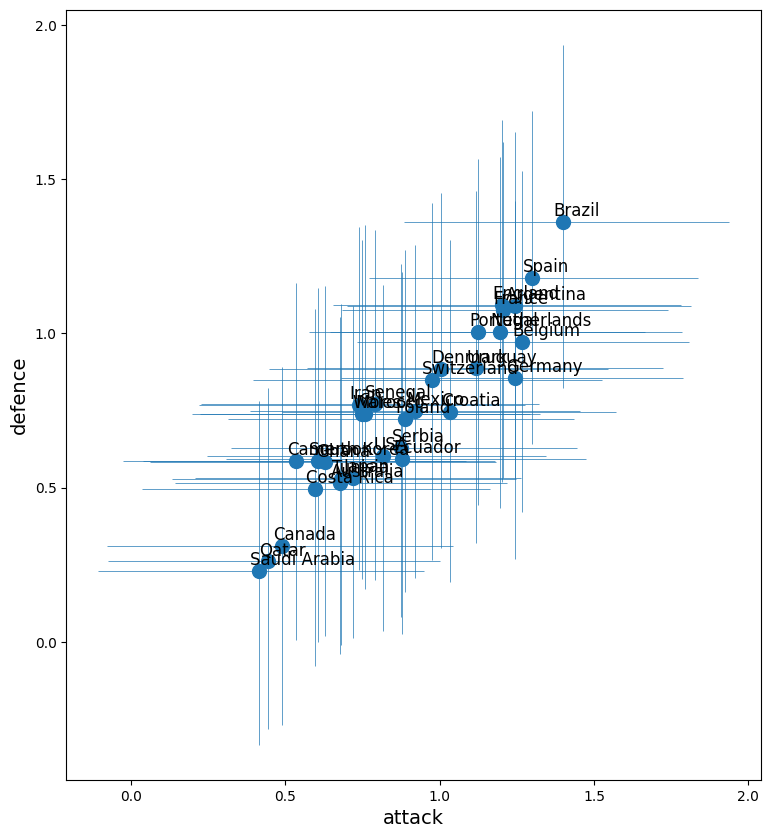

In [22]:
plot_attack_defence(wc_pred.model)

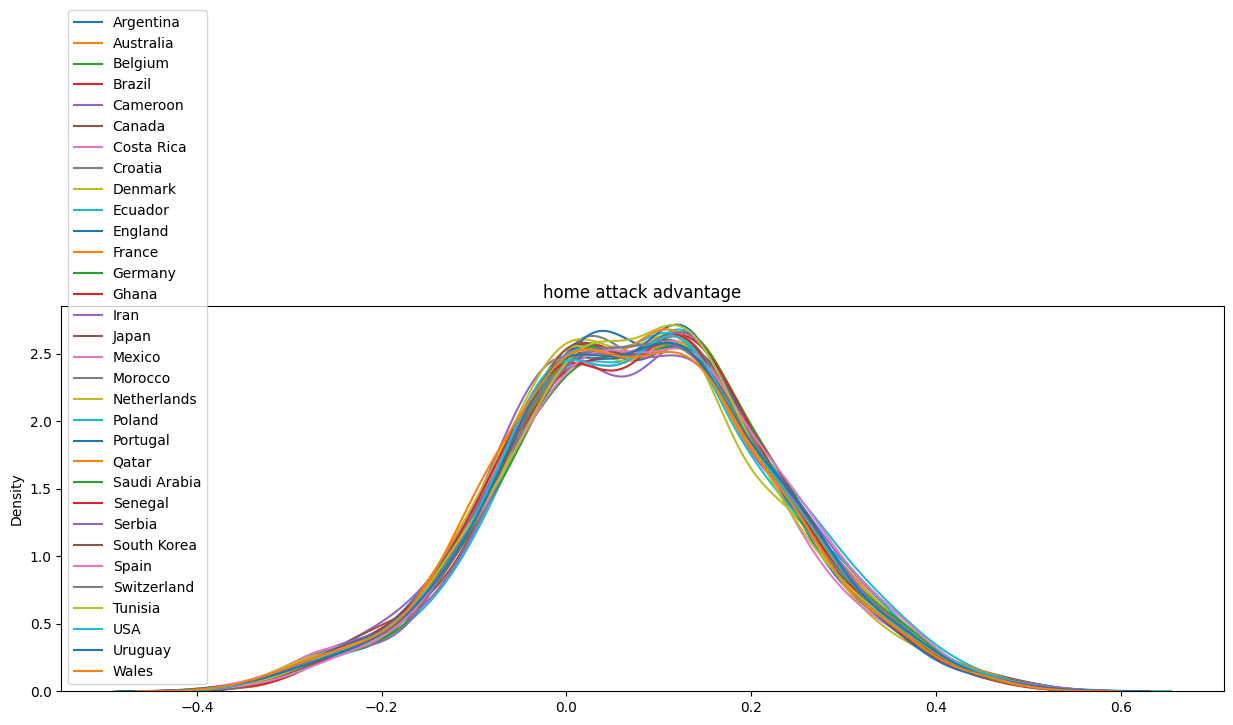

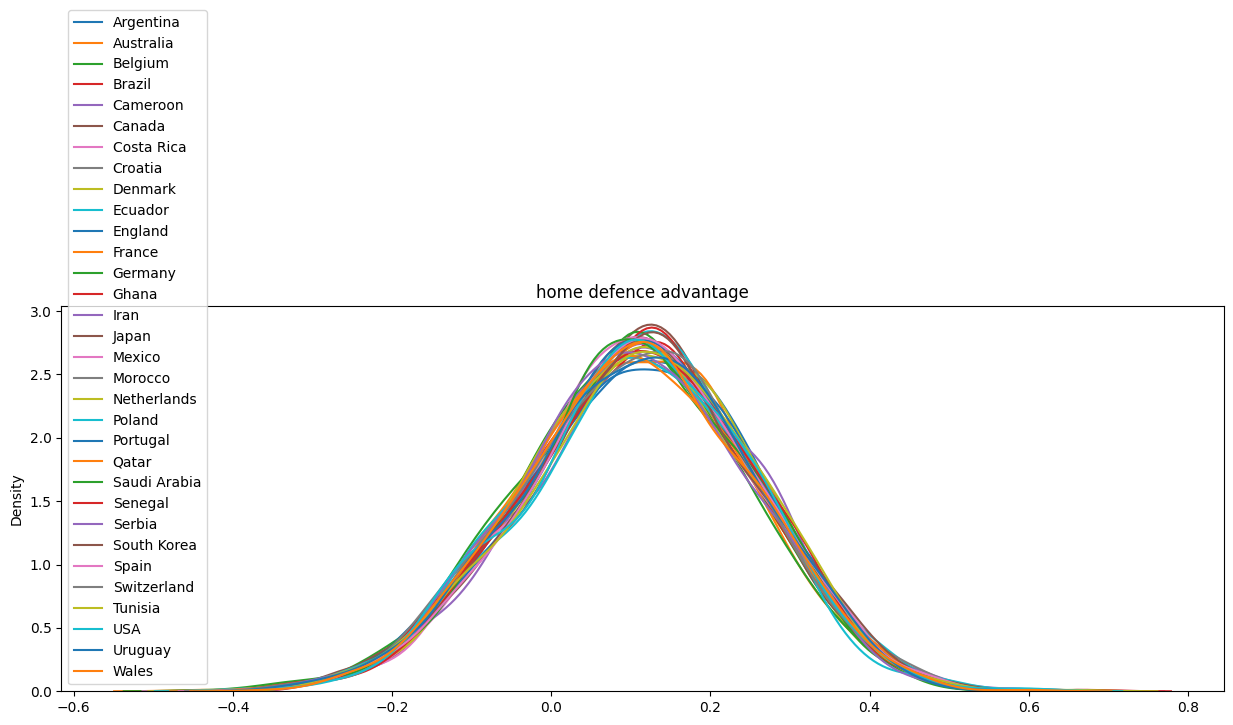

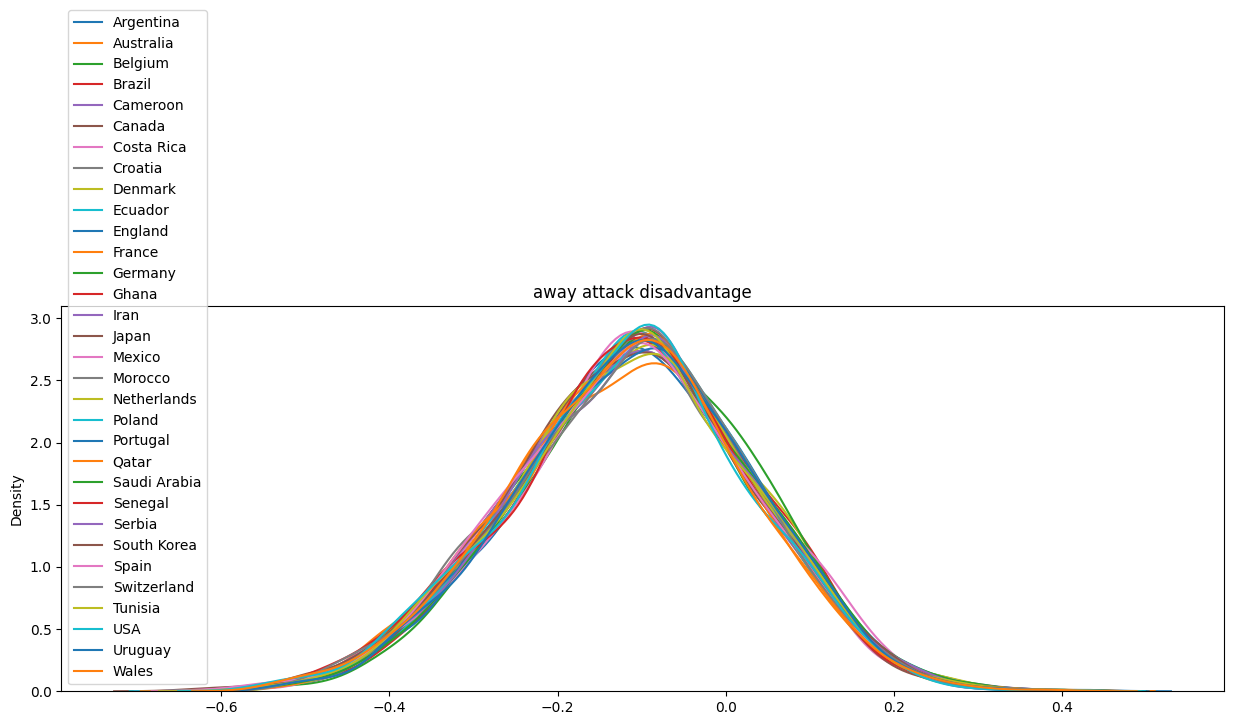

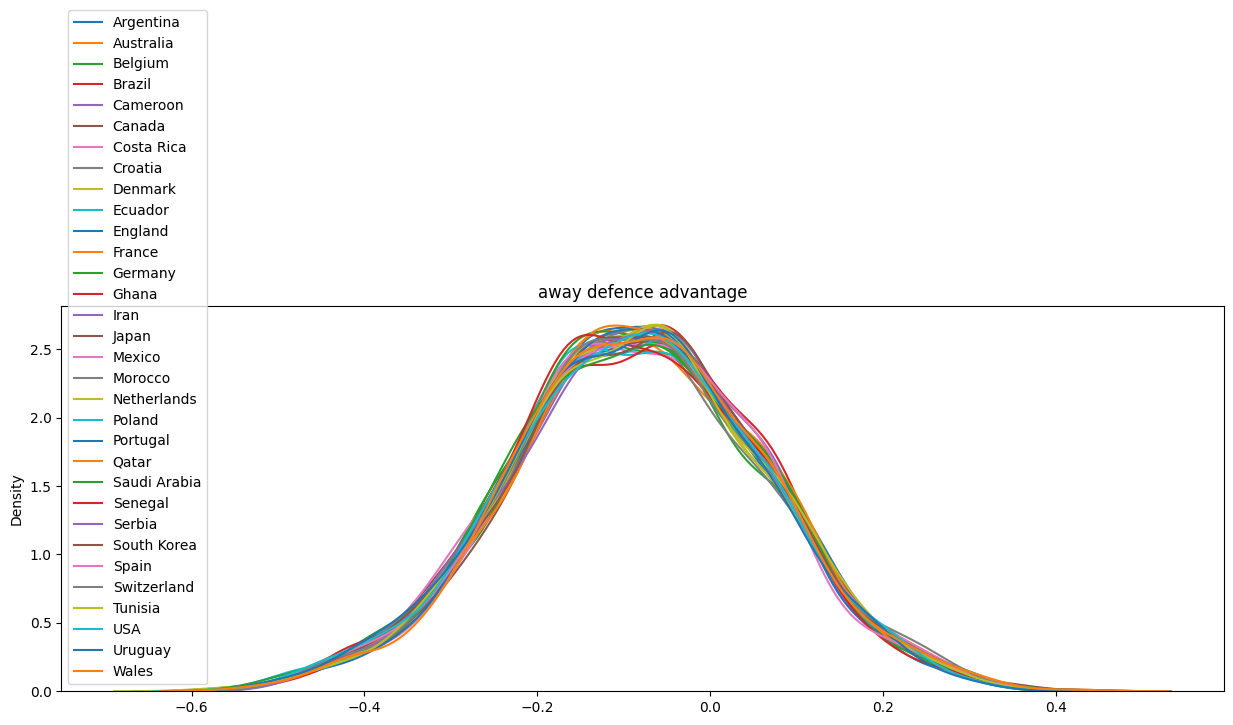

In [9]:
ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.home_attack[:, idx], label=team)
plt.title('home attack advantage')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.home_defence[:, idx], label=team)
plt.title('home defence advantage')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.away_attack[:, idx], label=team)
plt.title('away attack disadvantage')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.away_defence[:, idx], label=team)
plt.title('away defence advantage')
plt.legend()

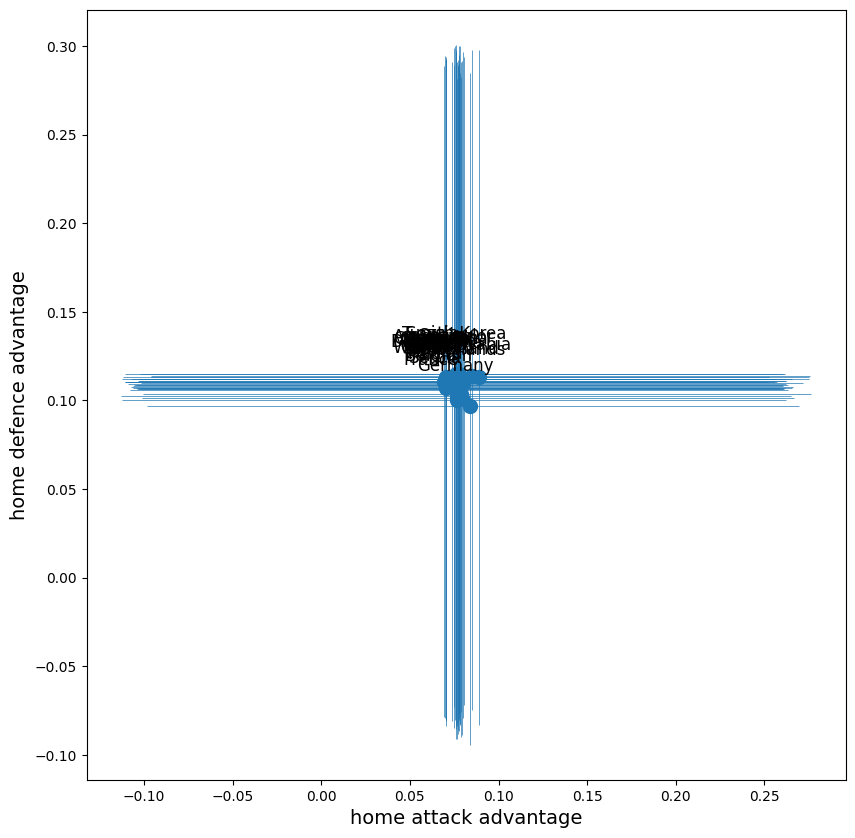

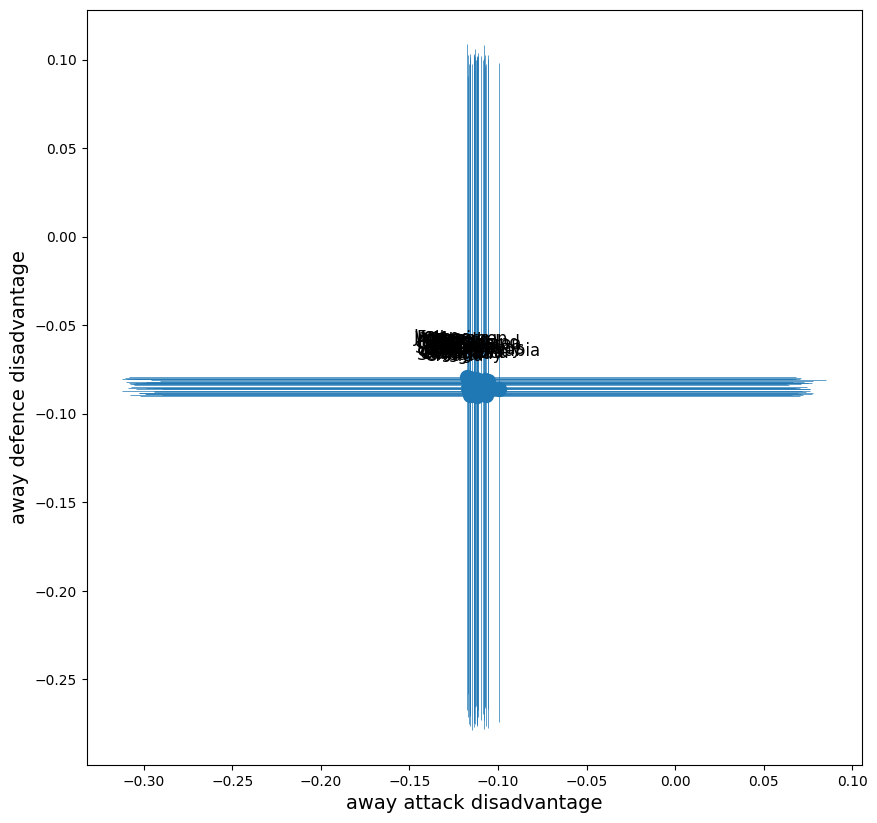

In [10]:
a_mean = wc_pred.model.home_attack.mean(axis=0)
b_mean = wc_pred.model.home_defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.home_attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.home_defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.home_attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.home_defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('home attack advantage', fontsize=14)
plt.ylabel('home defence advantage', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)

    
    
a_mean = wc_pred.model.away_attack.mean(axis=0)
b_mean = wc_pred.model.away_defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.away_attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.away_defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.away_attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.away_defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('away attack disadvantage', fontsize=14)
plt.ylabel('away defence disadvantage', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)


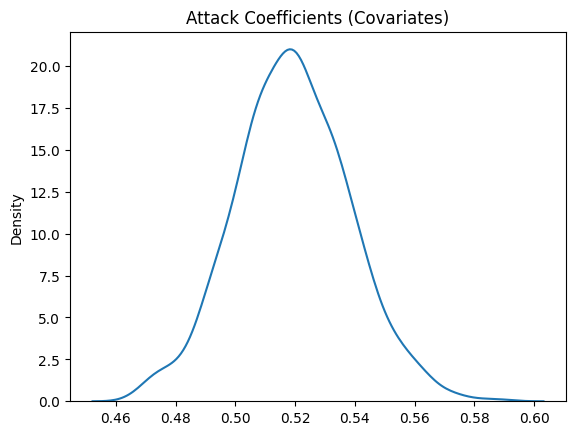

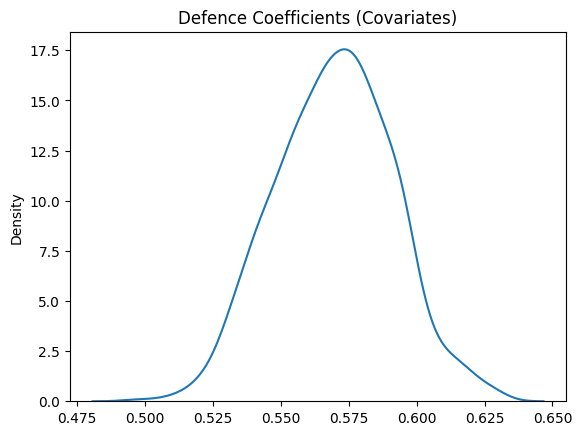

In [11]:
if wc_pred.model.attack_coefficients is not None:
    plt.figure()
    for i in range(wc_pred.model.attack_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.attack_coefficients[:, i])
    plt.title("Attack Coefficients (Covariates)")

    plt.figure()
    for i in range(wc_pred.model.defence_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.defence_coefficients[:, i])
    plt.title("Defence Coefficients (Covariates)")

## Using organisation rankings

In [12]:
wc_pred = wcpredictor.get_and_train_model(
    start_date=start_date,
    end_date=end_date,
    model=bpl.NeutralDixonColesMatchPredictorWC(),
    rankings_source="org"
)
dict(
    zip(
        wc_pred.model.conferences,
        wc_pred.model.confederation_strength.mean(axis=0).tolist(),
    )
)

in get_and_train_model
Using FIFA organisation rankings
Using 5523 rows in training data
Using FIFA organisation rankings
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:25<00:00, 17.49it/s, 63 steps of size 5.21e-02. acc. prob=0.91]


{'AFC': -0.08792721480131149,
 'CAF': 0.08479725569486618,
 'CONCACAF': -0.13219401240348816,
 'CONMEBOL': 0.08297808468341827,
 'OFC': -0.29341569542884827,
 'UEFA': 0.12320666015148163}

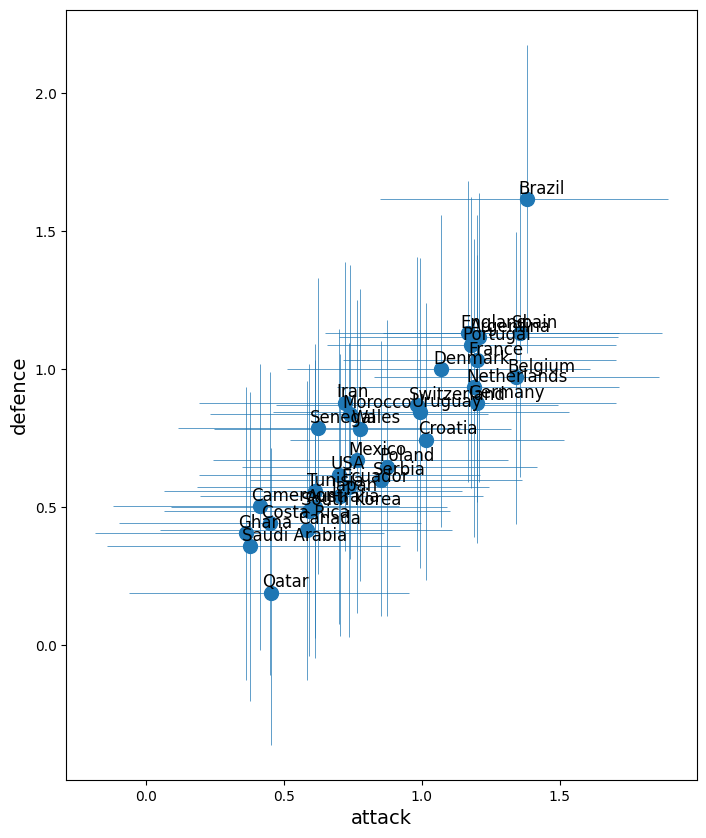

In [13]:
plot_attack_defence(wc_pred.model)

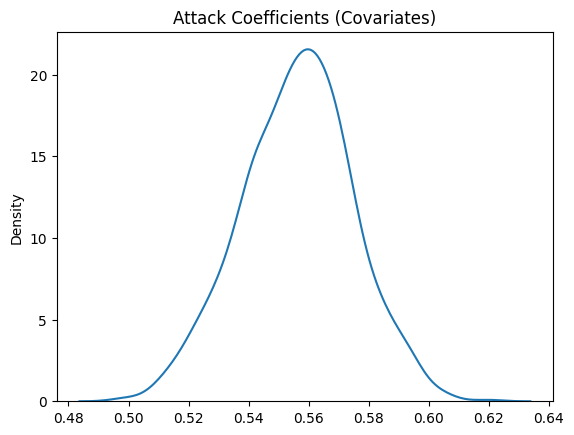

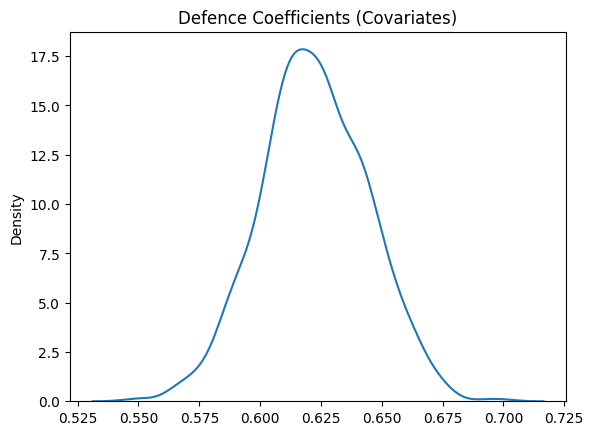

In [14]:
if wc_pred.model.attack_coefficients is not None:
    plt.figure()
    for i in range(wc_pred.model.attack_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.attack_coefficients[:, i])
    plt.title("Attack Coefficients (Covariates)")

    plt.figure()
    for i in range(wc_pred.model.defence_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.defence_coefficients[:, i])
    plt.title("Defence Coefficients (Covariates)")

## Use both Fifa organisation and Fifa game ratings

In [13]:
wc_pred = wcpredictor.get_and_train_model(
    start_date=start_date,
    end_date=end_date,
    model=bpl.NeutralDixonColesMatchPredictorWC(),
    rankings_source="both"
)

dict(
    zip(
        wc_pred.model.conferences,
        wc_pred.model.confederation_strength.mean(axis=0).tolist(),
    )
)

in get_and_train_model
Using FIFA videogame rankings
Using FIFA organisation rankings
Using 5523 rows in training data
Using FIFA videogame rankings
Using FIFA organisation rankings
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [05:16<00:00,  4.74it/s, 511 steps of size 1.19e-02. acc. prob=0.93]


{'AFC': -0.04895000159740448,
 'CAF': 0.09861724823713303,
 'CONCACAF': -0.10290316492319107,
 'CONMEBOL': 0.15274780988693237,
 'OFC': -0.302626371383667,
 'UEFA': 0.19335559010505676}

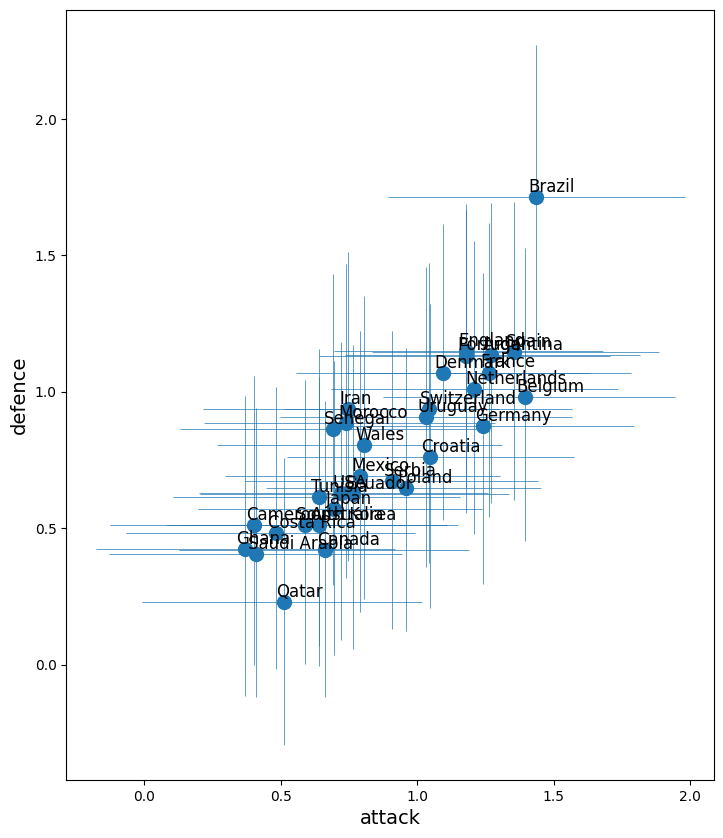

In [14]:
plot_attack_defence(wc_pred.model)

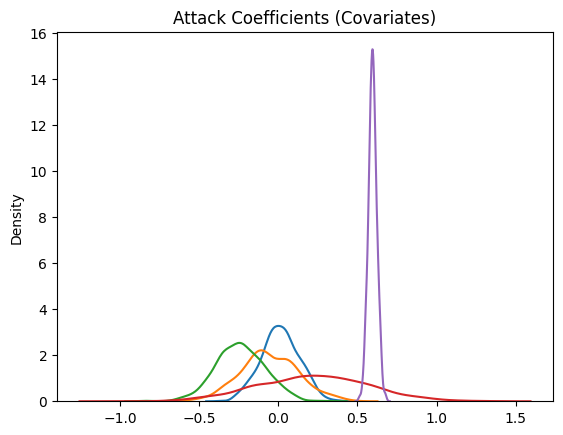

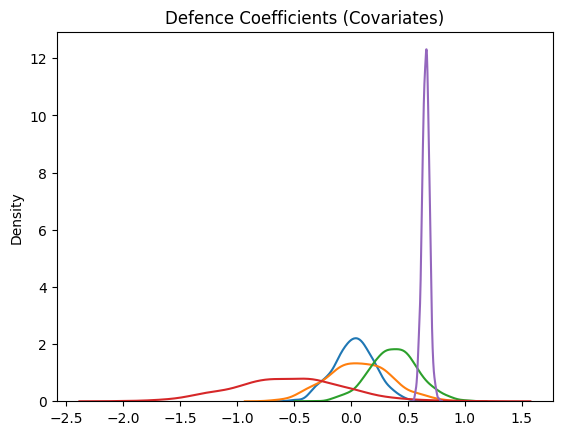

In [15]:
if wc_pred.model.attack_coefficients is not None:
    plt.figure()
    for i in range(wc_pred.model.attack_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.attack_coefficients[:, i])
    plt.title("Attack Coefficients (Covariates)")

    plt.figure()
    for i in range(wc_pred.model.defence_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.defence_coefficients[:, i])
    plt.title("Defence Coefficients (Covariates)")

## No covariates

In [16]:
wc_pred = wcpredictor.get_and_train_model(
    start_date=start_date,
    end_date=end_date,
    model=bpl.NeutralDixonColesMatchPredictorWC(),
    rankings_source=None
)

dict(
    zip(
        wc_pred.model.conferences,
        wc_pred.model.confederation_strength.mean(axis=0).tolist(),
    )
)

in get_and_train_model
Using 5866 rows in training data
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:23<00:00, 17.89it/s, 63 steps of size 5.29e-02. acc. prob=0.89]


{'AFC': -0.19532598555088043,
 'CAF': 0.14688564836978912,
 'CONCACAF': -0.37186115980148315,
 'CONMEBOL': 0.8613318800926208,
 'OFC': -0.8757781386375427,
 'UEFA': 0.5741826891899109,
 'Unaffiliated': -0.6600550413131714}

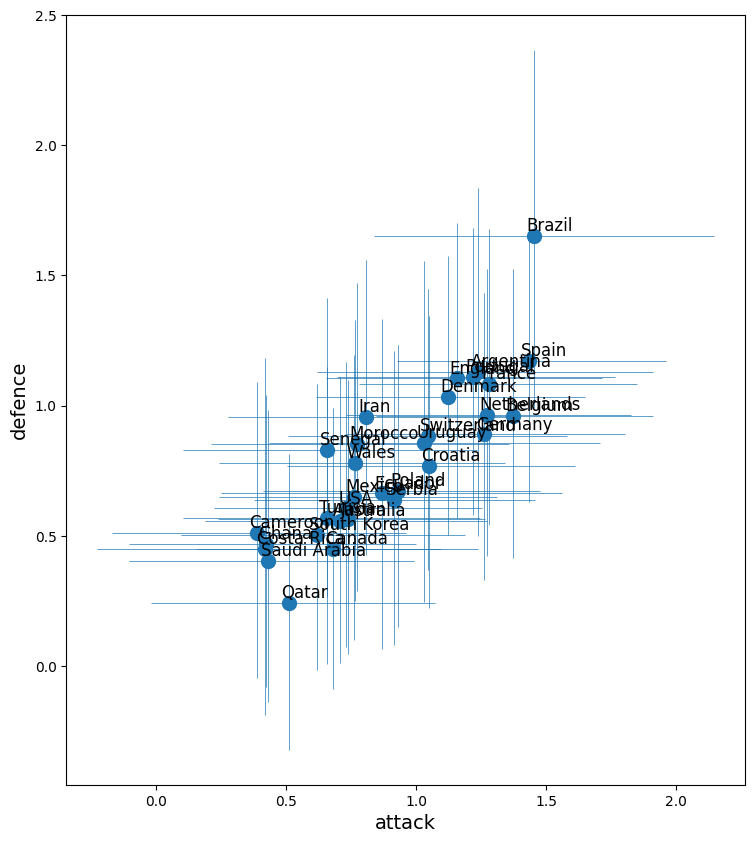

In [17]:
plot_attack_defence(wc_pred.model)

In [18]:
if wc_pred.model.attack_coefficients is not None:
    plt.figure()
    for i in range(wc_pred.model.attack_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.attack_coefficients[:, i])
    plt.title("Attack Coefficients (Covariates)")

    plt.figure()
    for i in range(wc_pred.model.defence_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.defence_coefficients[:, i])
    plt.title("Defence Coefficients (Covariates)")

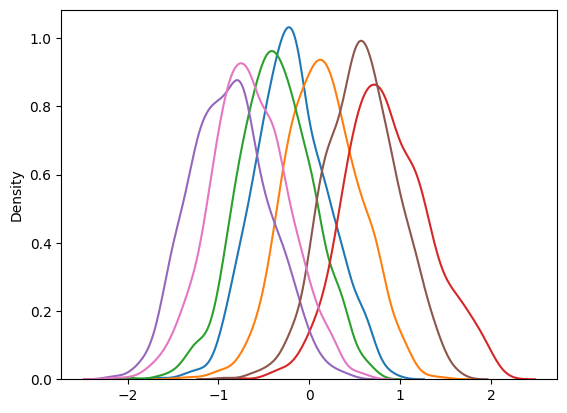

In [20]:
for idx in range(7):
    sns.kdeplot(wc_pred.model.confederation_strength[:, idx])